# MEG Data Preprocessing Pipeline - Subject 91

## Overview
This notebook implements a standardized preprocessing pipeline for OPM-MEG data analysis. The pipeline is designed for **subject sub-91** (healthy participant)
and processes one session at a time through a modular, reusable framework.

## Research Context
- **Subject**: sub-91 (healthy control participant)
- **Data Type**: OPM-MEG recordings (.fif format)

## Preprocessing Steps


### Libraries:

In [17]:
# ---- LIBRARIES ----
import json
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
sys.path.append('../source')
from find_paths import get_onedrive_path
from plot_functions import plot_channels_comparison
from config_manager import (load_and_display_config,
                            validate_file_selection,
                            preprocess_meg_data)

### Load configuration:

In [18]:
# ---- LOAD CONFIGURATION ----
# Add source directory to path for custom functions
sys.path.append('../source')

# Define subject for this notebook:
SUBJECT_ID = "sub-91" 

# Load and display configuration
config = load_and_display_config(SUBJECT_ID)

Configuration loaded for sub-91
SELECTABLE PARAMETERS:
DATA_TYPES: ['source_data', 'raw_data', 'processed_data']
SETUPS: ['setupA', 'setupB']
CONDITIONS:
  setupA: ['Move1', 'Move2', 'MoveMockDys', 'Rest', 'RestMockDys']
  setupB: ['Move', 'MoveMockDys', 'Rest', 'RestMockDys']


### Path Setup:

In [3]:
# Get base data path

base_data_path = get_onedrive_path('data')
print("Base data path found successfully")
print(f"Base path: {base_data_path}")


project folder found: /Users/federicobonato/OneDrive - Charité - Universitätsmedizin Berlin/TRR295 via Teams - LID_MEG - LID_MEG
Base data path found successfully
Base path: /Users/federicobonato/OneDrive - Charité - Universitätsmedizin Berlin/TRR295 via Teams - LID_MEG - LID_MEG/data


In [4]:
# ---- FILE SELECTION ----

print("\n" + "="*60)
print("USER SELECTION REQUIRED:")
print("Based on the available options above, define your selection:")

# USER DEFINES THESE PARAMETERS (the only place where selection happens)
DATA_TYPE = "raw_data"        # Choose from available DATA TYPES
SETUP = "setupA"              # Choose from available SETUPS  
CONDITION = "Move1"           # Choose from available CONDITIONS

print(f"\nSelected: {DATA_TYPE} -> {SETUP} -> {CONDITION}")

# Validate selection and construct path using config
filename, path_info = validate_file_selection(config, DATA_TYPE, SETUP, CONDITION)

# Construct complete file path using ALL config parameters
file_path = os.path.join(
    base_data_path,
    path_info['base_folder'],
    config['subject_id'],
    path_info['subfolder'],
    filename
)

print(f"Selected file: {filename}")
print(f"Full file path: {file_path}")
print(f"File exists: {os.path.exists(file_path)}")


USER SELECTION REQUIRED:
Based on the available options above, define your selection:

Selected: raw_data -> setupA -> Move1
Selected file: sub-91_OPM-MEG_setupA_Move1_raw.fif
Full file path: /Users/federicobonato/OneDrive - Charité - Universitätsmedizin Berlin/TRR295 via Teams - LID_MEG - LID_MEG/data/raw_data/sub-91/OPM_MEG/sub-91_OPM-MEG_setupA_Move1_raw.fif
File exists: True


In [5]:
# ---- LOAD AND EXPLORE DATA ----

# Load the MEG data
print(f"Loading file: {filename}")
raw = mne.io.read_raw_fif(file_path, preload=True, verbose=False)

print(f"\nData loaded successfully for {config['subject_id']}")
print("="*50)
print("DATA EXPLORATION:")
print("="*50)

# Basic data information
data_shape = raw.get_data().shape
print(f"Data shape: {data_shape}")
print(f"Number of channels: {raw.info['nchan']}")
print(f"Number of time points: {len(raw.times)}")
print(f"Sampling frequency: {raw.info['sfreq']} Hz")
print(f"Duration: {raw.times[-1]:.2f} seconds")


Loading file: sub-91_OPM-MEG_setupA_Move1_raw.fif

Data loaded successfully for sub-91
DATA EXPLORATION:
Data shape: (161, 390288)
Number of channels: 161
Number of time points: 390288
Sampling frequency: 2000.0 Hz
Duration: 195.14 seconds


### Data Summary

**Recording Information:**
- **Number of time points:** 390,288
- **Sampling frequency:** 2,000.0 Hz  
- **Duration:** 195.14 seconds (~3.25 minutes)

**Channel Configuration:**
- **Usable MEG channels:** 001 to 007 (7 channels total)


In [6]:
# ---- MEG CHANNELS ANALYSIS ----

# Get MEG channel mapping from config
meg_channel_map = config['meg_channels']

print(f"\nMEG CHANNELS MAPPING:")
print("="*30)
print(f"Total MEG channels: {len(meg_channel_map)}")
print("Channel mapping:")

for brain_region, meg_channel in meg_channel_map.items():
    print(f"  {brain_region} -> {meg_channel}")




MEG CHANNELS MAPPING:
Total MEG channels: 7
Channel mapping:
  C3 -> MEG001
  C4 -> MEG002
  CZ -> MEG003
  F3 -> MEG004
  F4 -> MEG005
  P3 -> MEG006
  P4 -> MEG007


## Preprocessing Pipeline

The following preprocessing steps will be applied to the MEG data to prepare it for analysis:

**Configuration Parameters:**
- Target sampling frequency: 512 Hz
- Bandpass filter: 1-100 Hz  
- Notch filter frequencies: 50, 100, 150 Hz

In [7]:
# ---- PREPROCESSING CONFIGURATION ----
print("\n" + "="*50)
print("PREPROCESSING CONFIGURATION:")
print("="*50)

# ---- DEFINE PREPROCESSING PARAMETERS AS CONSTANTS ----

TARGET_SFREQ = 512  # Target sampling frequency (Hz)
BANDPASS_LOW = 1    # Low frequency cutoff (Hz)
BANDPASS_HIGH = 100 # High frequency cutoff (Hz)
NOTCH_FREQS = [50, 100, 150]  # Line noise frequencies to remove (Hz)
MEG_SFREQ = raw.info['sfreq']  # Current sampling frequency

print(f"Current sampling frequency: {MEG_SFREQ} Hz")
print(f"Target sampling frequency: {TARGET_SFREQ} Hz")
print(f"Bandpass filter: {BANDPASS_LOW}-{BANDPASS_HIGH} Hz")
print(f"Notch filter frequencies: {NOTCH_FREQS} Hz")




PREPROCESSING CONFIGURATION:
Current sampling frequency: 2000.0 Hz
Target sampling frequency: 512 Hz
Bandpass filter: 1-100 Hz
Notch filter frequencies: [50, 100, 150] Hz


In [10]:
# ---- PREPROCESSING PIPELINE ----
# Apply complete preprocessing pipeline using configurable parameters
raw_preprocessed = preprocess_meg_data(
    raw=raw,
    first_sfreq=MEG_SFREQ,
    target_sfreq=TARGET_SFREQ,
    l_freq=BANDPASS_LOW,
    h_freq=BANDPASS_HIGH,
    notch_freqs=NOTCH_FREQS,
    verbose=True
)

# Store the result for further analysis
raw_filtered = raw_preprocessed


STEP 1: DOWNSAMPLING
No downsampling needed (already at 512 Hz)

STEP 2: FILTERING (LINE NOISE REMOVAL)
Applied bandpass filter: 1-100 Hz
Applied notch filters at: [50, 100, 150] Hz



MEG CHANNELS COMPARISON: RAW vs PREPROCESSED
Using 7 MEG channels: ['MEG 001', 'MEG 002', 'MEG 003', 'MEG 004', 'MEG 005', 'MEG 006', 'MEG 007']


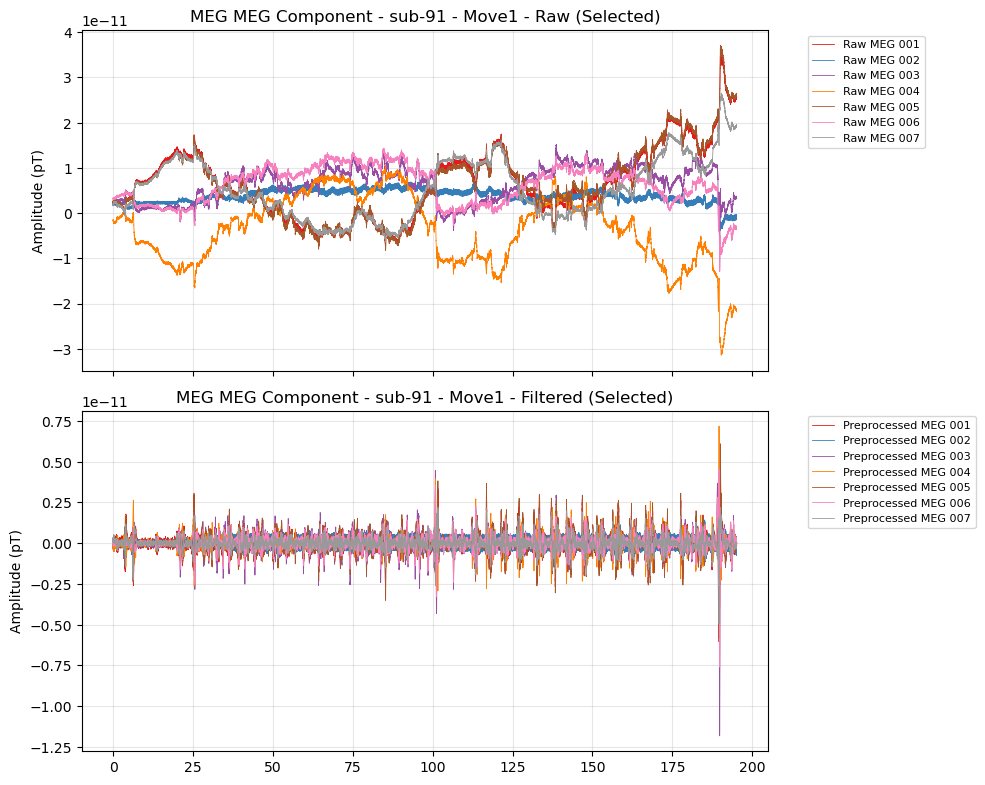

In [ ]:
# ---- VISUALIZE RAW VS PREPROCESSED COMPARISON ----
print("\n" + "="*60)
print("MEG CHANNELS COMPARISON: RAW vs PREPROCESSED")
print("="*60)

# Use first 7 MEG channels directly (non-hardcoded from config)
NUM_MEG_CHANNELS = len(config['meg_channels'])
meg_channel_indices = list(range(NUM_MEG_CHANNELS))
meg_channel_names = [raw.ch_names[i] for i in meg_channel_indices]

print(f"Using {NUM_MEG_CHANNELS} MEG channels: {meg_channel_names}")

# Get channel data (reuse existing variables)
raw_meg_channels = [raw.get_data()[idx] for idx in meg_channel_indices]
preprocessed_meg_channels = [raw_filtered.get_data()[idx] for idx in meg_channel_indices]


# Plot comparison

plot_channels_comparison(
    time=raw_filtered.times,
    raw_channels=raw_meg_channels,
    filtered_channels=preprocessed_meg_channels,
    raw_labels=[f"Raw {name}" for name in meg_channel_names],
    filtered_labels=[f"Preprocessed {name}" for name in meg_channel_names],
    colors=plt.cm.Set1(np.linspace(0, 1, NUM_MEG_CHANNELS)),
    rec_label=f"{SUBJECT_ID} - {CONDITION}",
    y_label="Amplitude (pT)",
    axis_label="MEG"
)
